# Poisson process fit to start times

Import packages & configure plots for dark mode:

In [1]:
import sys
sys.path.append("preprocess")
from preprocessing import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib.ticker import FuncFormatter
plt.style.use("dark_background") # Config plots for dark mode, delete if on light mode
plt.rcParams['figure.dpi'] = 150 # Hi-res plots

Calculate the poisson rate, $\lambda_i = \frac{N_i(T_i)}{T_i}$ for all stations:

Calculate and display the outliers in the rates:

In [2]:
rates = list(rates_dict.values())
cutoff = np.mean(rates) + 1.5*np.std(rates) # clearly nothing at minus 1.5sigma
max_rate = max(rates)
max_keys = [key for key, val in rates_dict.items() if val >= cutoff]
outliers = [get_station_name(i) for i in max_keys]
outliers

['Lansdowne Way Bus Garage, Stockwell',
 'George Row, Bermondsey',
 'Tower Wharf, Bermondsey']

In [77]:
np.mean(rates)

0.08832944139988277

Calculate the p-values for the different stations using the inter arrival times and the exponential distribution:

In [78]:
p_values = {}

for station in train_sorted_stations:
    station_id = station.start_id.unique()[0]
    rate = rates_dict[station_id]
    inter_arrival_times = station.start_time.diff().to_numpy() 
    inter_arrival_times[0] = station.start_time.to_numpy()[0] # change first inter-arrival time to t_1
    station_p_values = np.exp(-1* rate * inter_arrival_times)
    p_values[station_id] = station_p_values

p_values[1]

array([2.07616041e-16, 2.01660464e-03, 6.70324467e-04, ...,
       2.41633155e-01, 1.86645639e-02, 8.33170094e-04])

Histogram of the p-values:

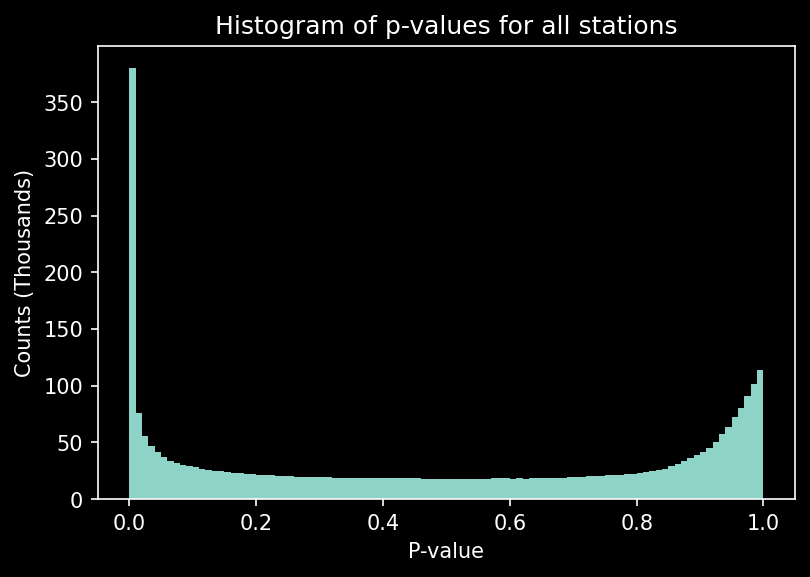

In [79]:
joined_p_values = np.concatenate(np.array(list(p_values.values()), dtype=object))
n, bins, patches = plt.hist(joined_p_values, bins=100)
ax = plt.gca()
def lblFormat(n, pos):
    return str(int(n / 1e3))
lblFormatter = FuncFormatter(lblFormat)
ax.yaxis.set_major_formatter(lblFormatter)
plt.title("Histogram of p-values for all stations")
plt.xlabel("P-value")
plt.ylabel("Counts (Thousands)")
plt.savefig("../figures/p-values.png")
plt.show()

Carry out and plot the Kolmogorov-Smirnov test on all the p-values to see if the poisson point process model is a good model for our data:

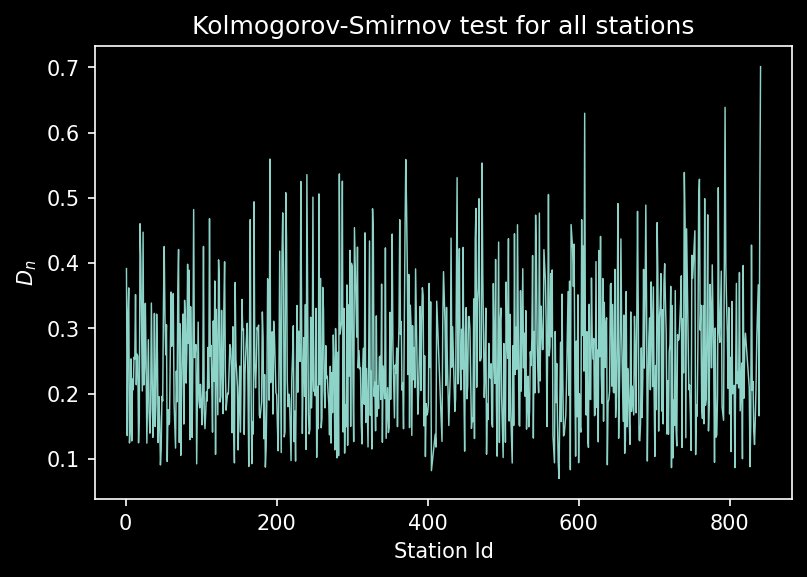

In [80]:
# Kolmogorov-smirnov:
kol_smir_test = {}
for station_id, pvals in p_values.items():
    kol_smir_test[station_id] = st.kstest(pvals, "uniform").statistic

plt.plot(kol_smir_test.keys(), kol_smir_test.values(), linewidth=0.7)
plt.title("Kolmogorov-Smirnov test for all stations")
plt.xlabel("Station Id")
plt.ylabel("$D_n$")
plt.savefig("../figures/kol-smir.png")
plt.show()

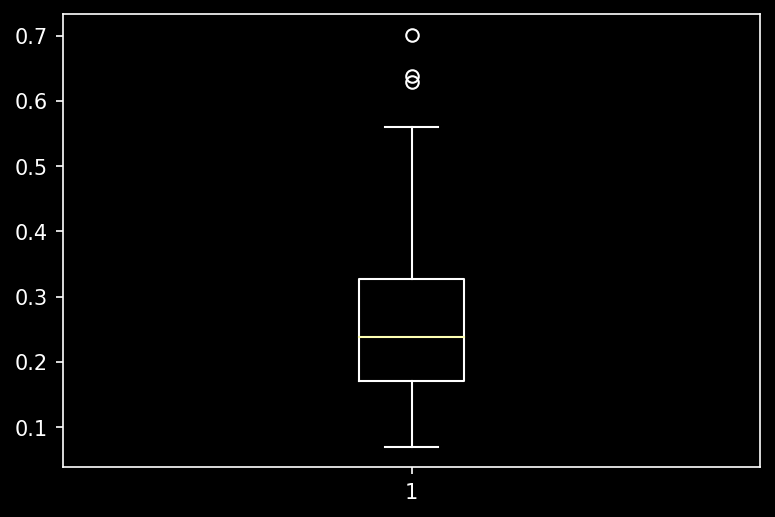

In [81]:
plt.boxplot(kol_smir_test.values())
plt.show()

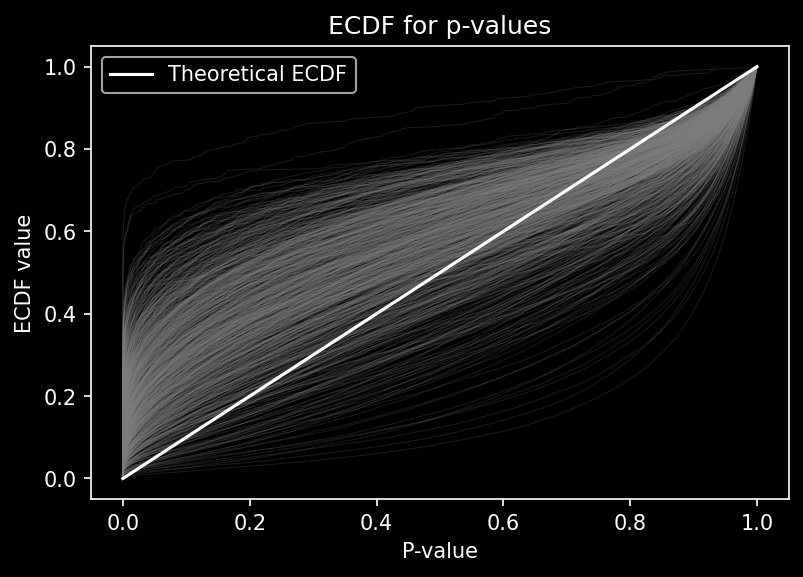

In [82]:
def ecdf(data): # https://cmdlinetips.com/2019/05/empirical-cumulative-distribution-function-ecdf-in-python/
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

for station, pvals in p_values.items():
    x,y = ecdf(pvals)
    plt.plot(x,y, alpha=0.2, linewidth=0.5, color="gray")

plt.title("ECDF for p-values")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], color="white", label="Theoretical ECDF")
plt.legend()
plt.show()